In [1]:
import os 
import cv2
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as Image
import tensorflow as tf
from skimage import transform
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score


# Data import & Pre-processing --------------------------------------------------------------------

In [2]:
# Gets paths for images 
def get_catalog(file):
    species = []
    pics = []
    for root, subdir, files in os.walk(file):
        species.append(subdir)
        pics.append(files)
    species = species[0]
    
    catalog = {}
    for i in range(len(species)):
        catalog[species[i]] = pics[i+1]
    return catalog

In [11]:
def data_augmentation(picture, save_loc,name):
    print(picture.shape)
    plt.imshow(picture)
    plt.show()
    flip_2 = tf.image.flip_up_down(picture)
    print(flip_2.shape)
    cv2.imwrite(save_loc + name[:-4] + 'a.jpg', np.array(flip_2))
    flip_3 = tf.image.flip_left_right(picture)
    cv2.imwrite(save_loc + name[:-4] + 'b.jpg', np.array(flip_3))
    flip_4 = tf.image.flip_up_down(flip_3)
    cv2.imwrite(save_loc + name[:-4] + 'c.jpg', np.array(flip_4))
    rot_90 = tf.image.rot90(picture, k=1)
    cv2.imwrite(save_loc + name[:-4] + 'd.jpg', np.array(rot_90))
    rot_180 = tf.image.rot90(picture, k=3)
    cv2.imwrite(save_loc + name[:-4] + 'e.jpg', np.array(rot_180))
    rot_2 = tf.image.rot90(flip_3, k=1)
    cv2.imwrite(save_loc + name[:-4] + 'f.jpg', np.array(rot_2))
    rot_3 = tf.image.rot90(flip_3, k=3)
    cv2.imwrite(save_loc + name[:-4] + 'g.jpg', np.array(rot_3))
    rot = transform.rotate(picture, angle=45, mode='reflect')
    plt.imshow(rot)
    plt.show()
    print(rot.shape)

In [4]:
def get_pics(catalog,path, species_index,pic_index, size):
    count = 1
    new_catalog = {}
    for specie in catalog:
        images =[]
        for i in range(pic_index):
            image = cv2.imread(path + specie + '/' + catalog[specie][i])
            data_augmentation(image,path + specie + '/',catalog[specie][i])
            #res = cv2.resize(image, dsize=size, interpolation=cv2.INTER_NEAREST)
            #images.append(res.flatten())
        #new_catalog[specie] = np.array(images)
        if count == species_index:
            break
        count += 1
        
    return new_catalog

In [5]:
def import_pics2(path, nspec, npic,shape):
    bird_catalog = get_catalog(path)
    pics = get_pics(bird_catalog,path, nspec, npic,shape)
    return pics

In [ ]:
def get_Xy(pictures):
    test_images = []
    labels = []
    count = 0
    for species, values in pictures.items():
        if len(test_images) == 0:
            test_images = values
            labels = np.repeat(count,values.shape[0])
        else:
            test_images = np.concatenate((test_images,values),axis=0)
            labels = np.concatenate((labels, np.repeat(count, values.shape[0])),axis=0)
        count +=1
    test_images = np.array(test_images)
    return test_images, np.array(labels)

In [ ]:
def dim_reduction(X):
    X = StandardScaler().fit_transform(X)
    pca = PCA(random_state=seed).fit(X)
    new_X = pca.transform(X)
    print("Dim reduction ready.")
    return new_X, pca

In [ ]:
def dim_reduction_kernelcosine(X):
    kpca = KernelPCA(kernel='cosine',random_state=seed).fit(X)
    new_X = kpca.transform(X)
    print("Kernel PCA cosine ready")
    return new_X, kpca

In [ ]:
def dim_reduction_kernelpoly(X):
    kpca = KernelPCA(kernel='poly',random_state=seed).fit(X)
    new_X = kpca.transform(X)
    print("Kernel PCA poly ready")
    return new_X, kpca

(224, 224, 3)


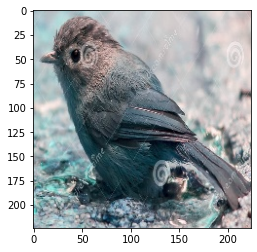

(224, 224, 3)


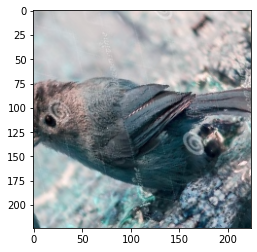

(224, 224, 3)


In [12]:
# Main function for data preprocessing ----------------------------------------------------------------------------------
seed = 2
np.random.RandomState(seed)

#Declare variables 
train_file, valid_file, test_file = 'data/birds/train/', 'data/birds/valid/', 'data/birds/test/'
num_species = 1
num_pics_train, num_pics_val, num_pics_test = 1, 0, 0
size = (64,64)

#get pictures
train_pictures = import_pics2(train_file, num_species, num_pics_train,size)
valid_pictures = import_pics2(valid_file, num_species, num_pics_val,size)
test_pictures = import_pics2(test_file, num_species, num_pics_test,size)

# Dimensionality Reduction -------------------------------------------------------------------------

In [ ]:
def eigendecomposition(images):
    species_values = {}
    for specie, values in images.items():
        mean = np.mean(values,axis=0)
        x = (values-mean)/ 255
        U, S, V = np.linalg.svd(x.T,full_matrices=False)
        species_values[specie] = [U, S, mean]
    print("Done eigendecomposing.")
    return species_values

In [ ]:
def get_eigenspecies(eigen,n_comp):
    species_eigenvectors = {}
    for spec, vals in  eigen.items():
        U = vals[0]
        mean = vals[2]
        eigenvs =  U[:,:n_comp]
        species_eigenvectors[spec] = (eigenvs, mean)
    print("Done getting eigenspecies.")
    return species_eigenvectors

In [ ]:
def get_residuals(eigenspecies,test):
    residuals_matrix = []
    test = test / 255
    matrix_residual = []
    for image in test:
        per_species_residual = []
        for specie, metrics in eigenspecies.items():
            pre_image = image - (metrics[1]/255)
            residual = np.linalg.norm(pre_image - (metrics[0] @ metrics[0].T @ pre_image))**2
            per_species_residual.append(residual)
        matrix_residual.append(per_species_residual) 
    print("Done getting residuals.")
    return np.array(matrix_residual)

In [ ]:
start = time.time()
eigenvectors = eigendecomposition(train_pictures)
eigenspecies = get_eigenspecies(eigenvectors, 90)
X_test, y_test = get_Xy(test_pictures)
residuals = get_residuals(eigenspecies,X_test)
end = time.time()
print(end-start)

In [ ]:
classification = residuals.argmin(axis=1) + 1
print(accuracy_score(y_test,classification))

# Density Estimation -----------------------------------------------------------------------------------

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
def retrieve_info(cluster_labels,y_train):
    reference_labels = {}
    
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [ ]:
def k_means(seed,num_clust,X,y):
    clf_km = KMeans(n_clusters=num_clust,random_state=seed).fit(X)
    map_kmlabels = retrieve_info(clf_km.labels_,y)
    km_labels = [map_kmlabels[i] for i in clf_km.labels_]
    return map_kmlabels, clf_km

In [ ]:
def sphere_k_means(seed,num_clust,X,y):
    clf_skm = SphericalKmeans(n_clusters=num_clust)
    map_kmlabels = retrieve_info(clf_skm.labels_,y)
    km_labels = [map_kmlabels[i] for i in clf_km.labels_]
    return map_kmlabels, clf_km
    

In [ ]:
X_train, y_train = get_Xy(train_pictures)
X_test, y_test = get_Xy(test_pictures)

#X_pctrain, dim_reductor = dim_reduction(X_train)
#X_pctest = dim_reductor.transform(X_test)

In [ ]:
mapping, model = k_means(seed, 125, X_train, y_train)
pred = model.predict(X_test)
translated_pred = [mapping[i] for i in pred]
print(accuracy_score(translated_pred, y_test))

#mapping2, model2 = sphere_k_means(seed, 125, X_train, y_train)
#pred2 = model2.predict(X_test)
#translated_pred2 = [mapping2[i] for i in pred2]
#print(accuracy_score(translated_pred2, y_test))

In [ ]:
accuracy = []
cluster = []
sil = []
for i in np.arange(2,150,5):
    mapping, model = k_means(seed, i, X_train, y_train)
    pred = model.predict(X_test)
    translated_pred = [mapping[i] for i in pred]
    sil.append(silhouette_score(X_train, model.labels_, metric = 'euclidean', random_state=seed))
    accuracy.append(accuracy_score(translated_pred, y_test))
    cluster.append(i)
    print('Iteration ' + str(i) + " complete.")
plt.plot(cluster,sil)
plt.show()
plt.plot(cluster, accuracy)
plt.show()



In [ ]:
pred = model.predict(X_test)
translated_pred = [mapping[i] for i in pred]
print(accuracy_score(translated_pred, y_test))

# Traditional Classification --------------------------------------------------------------------------

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
def train_model(X, label):
    
    knn = KNeighborsClassifier()
    n_neighbors = {'n_neighbors': list(range(1, 31))}
    
    lr = LogisticRegression(max_iter=1000,random_state=seed)
    
    svm = SVC()
    kernel = {'kernel':('linear','rbf'),'C': [0.1, 1, 10, 100],'gamma': [1, 0.1, 0.01, 0.001]}
    
    clf_svm = GridSearchCV(svm,kernel).fit(X,label)
    print("SVM done.")
    clf_knn = GridSearchCV(knn,n_neighbors).fit(X,label)
    print("KNN done")
    
    print(clf_knn.best_score_)
    print(clf_svm.best_score_)
    print(np.mean(cross_val_score(lr,X,label,cv=5)))
    print("LR done")
    

In [ ]:
def build_model(X, label):
    return
    

In [ ]:

X, y = get_Xy(train_pictures)
X, kpca = dim_reduction_kernelcosine(X)
train_model(X, y)

X, y = get_Xy(train_pictures)
X, kpca = dim_reduction_kernelpoly(X)
train_model(X, y)


X, y = get_Xy(train_pictures)
X, pca = dim_reduction(X)
train_model(X, y)

# Deep Learning -----------------------------------------------------------------------------------------

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def deep_pre_process(image_catalog, og_shape):
    X, y = get_Xy(image_catalog)
    tenso_X = np.reshape(X,(X.shape[0], og_shape[0], og_shape[1], 3))
    tenso_X = tenso_X.astype('float32')
    tenso_X = tenso_X / 255.
    
    y_one_hot = to_categorical(y)
    return tenso_X, y_one_hot
    

In [ ]:
X_train, y_train = deep_pre_process(train_pictures, size)
X_val, y_val = deep_pre_process(valid_pictures, size)
X_test, y_test = deep_pre_process(test_pictures, size)

## Neural Network implementation 

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(shape,classes):
    bird_model = Sequential()
    bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(shape[1],shape[2],shape[3]),padding='same'))
    bird_model.add(LeakyReLU(alpha=0.1))
    bird_model.add(MaxPooling2D((2, 2),padding='same'))
    bird_model.add(Dropout(0.25))
    bird_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    bird_model.add(LeakyReLU(alpha=0.1))
    bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    bird_model.add(Dropout(0.25))
    bird_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    bird_model.add(LeakyReLU(alpha=0.1))                  
    bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    bird_model.add(Dropout(0.4))
    bird_model.add(Flatten())
    bird_model.add(Dense(128, activation='linear'))
    bird_model.add(LeakyReLU(alpha=0.1))           
    bird_model.add(Dropout(0.3))
    bird_model.add(Dense(classes, activation='softmax'))
    
    bird_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(),metrics=['accuracy'])
    print(bird_model.summary())
    return bird_model

In [ ]:
batch_size = 64
epochs = 20
num_classes = num_species

In [ ]:
clf_cnn = build_model(X_train.shape, num_classes)


In [ ]:
bird_train = clf_cnn.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val))

In [ ]:
test_eval = clf_cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [ ]:
accuracy = bird_train.history['accuracy']
val_accuracy = bird_train.history['val_accuracy']
loss = bird_train.history['loss']
val_loss = bird_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.legend()
plt.show()